Paper: https://arxiv.org/abs/2003.00295

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.ops import MLP
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100, CIFAR10, MNIST
import copy
from tqdm import tqdm
from collections import OrderedDict
import random
import math
import matplotlib.pyplot as plt
from client_selector import ClientSelector
from data_splitter import DataSplitter

In [4]:
!pip install wandb -qU
import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

In [19]:
K = 100

params = {
    'K': K,
    'C': 0.1,
    'B': 64,
    'J': 4,
    # 'lr_server': 1e-1,
    'lr_client': 1e-1,
    'method': 'fedavg',
    'tau': 1e-3,
    'gamma': 0.1,
    'participation': 'uniform',
    'rounds': 2000
}

In [20]:
preprocess = transforms.Compose([
    transforms.RandomCrop((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
])

train_dataset = CIFAR100('datasets/cifar100', train=True, transform=preprocess, download=True)
test_dataset = CIFAR100('datasets/cifar100', train=False, transform=preprocess, download=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
data_split_params = {
    'K': K,
    'split_method': 'iid'
}

data_splitter = DataSplitter(data_split_params, train_dataset)
client_datasets = data_splitter.split()

In [22]:
client_selector = ClientSelector(params)

## Model

In [23]:
class LeNet5_circa(nn.Module):
    def __init__(self):
        super( LeNet5_circa, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(4 * 4 * 64, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 100)

    def forward(self, x):
        x = self.pool(self.conv1(x).relu())
        x = self.pool(self.conv2(x).relu())
        x = torch.flatten(x, 1)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)

        return x


model = LeNet5_circa().cuda()
model.to('cuda')

criterion = torch.nn.CrossEntropyLoss().cuda()

In [24]:
wandb.init(
    project='fl',
    name=f'fed {data_split_params["split_method"]}, J={params["J"]}, lr={params["lr_client"]}',
    config={**params, **data_split_params}
)

acc,▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇███
loss,████████▇▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
round,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
acc,18.36
loss,3.44579
round,1250


In [25]:
path = lambda t: f'/content/drive/My Drive/fl/{data_split_params["split_method"]}-J{params["J"]}-lr{params["lr_client"]}-{t}.pt'

backup = 0
if backup:
    model.load_state_dict(torch.load(path(backup)))
model

LeNet5_circa(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=100, bias=True)
)

## Utils

In [26]:
def reduce_w(w_list, f):
    return OrderedDict([
            (key, f([x[key] for x in w_list])) for key in w_list[0].keys()
        ])


def tensor_sum(tensors_list):
    return torch.sum(torch.stack(tensors_list), dim=0)


def w_norm2(w):
    res = 0
    for key in w.keys():
        res += torch.linalg.vector_norm(w[key]) ** 2
    return math.sqrt(res)


def fed_adagrad(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return v + delta_norm2


def fed_yogi(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return v - (1-params['beta2']) * delta_norm2 * torch.sign(v - delta_norm2)


def fed_adam(v, delta, params):
    delta_norm2 = w_norm2(delta)
    return params['beta2'] * v + (1-params['beta2']) * delta_norm2


methods = {
    'adagrad': fed_adagrad,
    'yogi': fed_yogi,
    'adam': fed_adam
}

## Training

In [27]:
T = params['rounds']
test_freq = 50
save_freq = 200

In [28]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100. * correct / total
    print(f'Test Loss: {test_loss:.6f} Acc: {test_accuracy:.2f}%')
    return test_accuracy, test_loss


def client_update(model, k, params):
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=params['lr_client'], weight_decay=4e-4)
    loader = DataLoader(client_datasets[k], batch_size=params['B'], shuffle=True)

    i = 0
    for i in range(params['J']):
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            i += 1

            if i >= params['J']:
              return model.state_dict()

    return model.state_dict()


def train(model, params):
    accuracies = []
    losses = []
    v = params['tau'] ** 2
    w = model.state_dict()
    m = reduce_w([w], lambda x: torch.mul(x[0], 0.0))
    for t in tqdm(range(backup, T)):
        s = client_selector.sample()

        w_clients = []
        for k in s:
            w_clients.append(client_update(copy.deepcopy(model), k, params))

        if params['method'] == 'fedavg':
            w = reduce_w(
                w_clients,
                lambda x: tensor_sum(x) / len(w_clients)
            )
        else:
            deltas = [
                reduce_w(
                    [w, w_client],
                    lambda x: x[1] - x[0]
                ) for w_client in w_clients
            ]

            # n_weights = [len(client_datasets[k])/len(w_clients) for k in s]
            delta = reduce_w(
                deltas,
                lambda x: tensor_sum(x) / len(deltas)
            )

            m = reduce_w(
                [m, delta],
                lambda x: params['beta1'] * x[0] + (1-params['beta1']) * x[1]
            )

            v = methods[params['method']](v, delta, params)
            w = reduce_w(
                [w, m],
                lambda x: x[0] + params['lr_server'] * x[1] / (math.sqrt(v) + params['tau'])
            )

        model.load_state_dict(w)

        if t % test_freq == 0 or t == T-1:
            acc, loss = test(model)
            accuracies.append(acc)
            losses.append(loss)
            wandb.log({'acc': acc, 'loss': loss, 'round': t})

        if t % save_freq == 0 or t == T-1:
            torch.save(model.state_dict(), path(t))

    return accuracies, losses


accuracies, losses = train(model, params)

  0%|          | 0/2000 [00:00<?, ?it/s]

Test Loss: 4.605316 Acc: 1.12%


  3%|▎         | 51/2000 [01:05<1:15:11,  2.31s/it]

Test Loss: 4.114709 Acc: 7.16%


  5%|▌         | 101/2000 [02:03<1:07:25,  2.13s/it]

Test Loss: 3.823276 Acc: 11.98%


  8%|▊         | 151/2000 [03:02<1:03:10,  2.05s/it]

Test Loss: 3.615068 Acc: 15.90%


 10%|█         | 201/2000 [04:00<1:11:36,  2.39s/it]

Test Loss: 3.456404 Acc: 18.76%


 13%|█▎        | 251/2000 [04:58<1:09:48,  2.39s/it]

Test Loss: 3.306385 Acc: 21.33%


 15%|█▌        | 301/2000 [05:57<1:02:18,  2.20s/it]

Test Loss: 3.208571 Acc: 22.92%


 18%|█▊        | 351/2000 [06:53<58:05,  2.11s/it]

Test Loss: 3.096826 Acc: 24.98%


 20%|██        | 401/2000 [07:51<56:41,  2.13s/it]

Test Loss: 3.002823 Acc: 27.45%


 23%|██▎       | 451/2000 [08:50<55:20,  2.14s/it]

Test Loss: 2.932247 Acc: 28.27%


 25%|██▌       | 501/2000 [09:48<1:01:03,  2.44s/it]

Test Loss: 2.846690 Acc: 29.92%


 28%|██▊       | 551/2000 [10:46<58:18,  2.41s/it]

Test Loss: 2.756768 Acc: 31.58%


 30%|███       | 601/2000 [11:45<50:48,  2.18s/it]

Test Loss: 2.709045 Acc: 32.21%


 33%|███▎      | 651/2000 [12:43<48:16,  2.15s/it]

Test Loss: 2.626887 Acc: 33.87%


 35%|███▌      | 701/2000 [13:41<48:20,  2.23s/it]

Test Loss: 2.584659 Acc: 34.91%


 38%|███▊      | 751/2000 [14:40<49:52,  2.40s/it]

Test Loss: 2.526926 Acc: 36.12%


 40%|████      | 801/2000 [15:38<44:10,  2.21s/it]

Test Loss: 2.497242 Acc: 37.46%


 43%|████▎     | 851/2000 [16:34<39:57,  2.09s/it]

Test Loss: 2.459594 Acc: 37.46%


 45%|████▌     | 901/2000 [17:32<38:37,  2.11s/it]

Test Loss: 2.414130 Acc: 38.29%


 48%|████▊     | 951/2000 [18:28<35:54,  2.05s/it]

Test Loss: 2.393044 Acc: 38.48%


 50%|█████     | 1001/2000 [19:25<35:20,  2.12s/it]

Test Loss: 2.375942 Acc: 39.30%


 53%|█████▎    | 1051/2000 [20:23<37:49,  2.39s/it]

Test Loss: 2.342414 Acc: 39.80%


 55%|█████▌    | 1101/2000 [21:21<36:21,  2.43s/it]

Test Loss: 2.370960 Acc: 39.52%


 58%|█████▊    | 1151/2000 [22:18<32:22,  2.29s/it]

Test Loss: 2.322912 Acc: 40.64%


 60%|██████    | 1201/2000 [23:16<28:27,  2.14s/it]

Test Loss: 2.324734 Acc: 40.39%


 63%|██████▎   | 1251/2000 [24:13<25:51,  2.07s/it]

Test Loss: 2.306261 Acc: 41.13%


 65%|██████▌   | 1301/2000 [25:09<23:52,  2.05s/it]

Test Loss: 2.268048 Acc: 41.96%


 68%|██████▊   | 1351/2000 [26:08<26:00,  2.41s/it]

Test Loss: 2.274275 Acc: 42.36%


 70%|███████   | 1401/2000 [27:05<23:48,  2.39s/it]

Test Loss: 2.269155 Acc: 42.37%


 73%|███████▎  | 1451/2000 [28:02<21:09,  2.31s/it]

Test Loss: 2.262640 Acc: 42.47%


 75%|███████▌  | 1501/2000 [29:00<17:42,  2.13s/it]

Test Loss: 2.251049 Acc: 42.78%


 78%|███████▊  | 1551/2000 [29:55<15:20,  2.05s/it]

Test Loss: 2.282869 Acc: 42.36%


 80%|████████  | 1601/2000 [30:51<13:40,  2.06s/it]

Test Loss: 2.246107 Acc: 43.00%


 83%|████████▎ | 1651/2000 [31:48<12:12,  2.10s/it]

Test Loss: 2.263553 Acc: 43.36%


 85%|████████▌ | 1701/2000 [32:45<11:27,  2.30s/it]

Test Loss: 2.264304 Acc: 43.01%


 88%|████████▊ | 1751/2000 [33:42<09:52,  2.38s/it]

Test Loss: 2.251248 Acc: 43.55%


 90%|█████████ | 1801/2000 [34:40<07:31,  2.27s/it]

Test Loss: 2.256113 Acc: 43.77%


 93%|█████████▎| 1851/2000 [35:37<05:18,  2.13s/it]

Test Loss: 2.251458 Acc: 43.89%


 95%|█████████▌| 1901/2000 [36:34<03:29,  2.11s/it]

Test Loss: 2.284179 Acc: 43.55%


 98%|█████████▊| 1951/2000 [37:32<01:42,  2.08s/it]

Test Loss: 2.280554 Acc: 43.41%


100%|██████████| 2000/2000 [38:32<00:00,  1.16s/it]

Test Loss: 2.283793 Acc: 43.26%


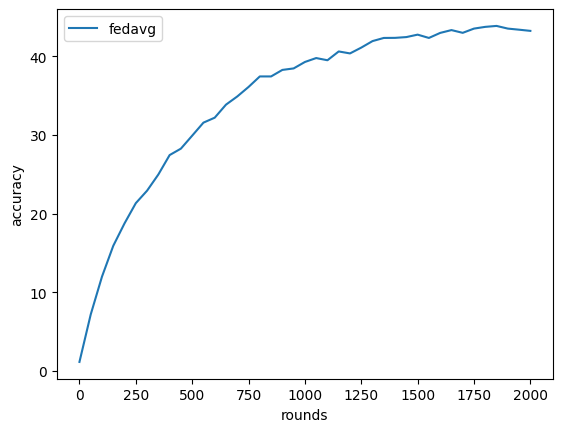

In [30]:
plt.xlabel('rounds')
plt.ylabel('accuracy')
xx = np.arange(0, T + test_freq, test_freq)
plt.plot(xx, accuracies, label=params['method'], marker='')
plt.legend()